In [2]:
!nvidia-smi

Mon Jan  3 04:37:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:1B:00.0 Off |                  Off |
| 40%   64C    P2   243W / 260W |   6102MiB / 48601MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:1C:00.0 Off |                  Off |
| 43%   

In [ ]:
!pip install torchsummary

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import os
import copy

import random
import torch
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torchsummary import summary

from trainer import *
from loss import *
from Unet import *
from preprocessing import *
from datagenerater import *
from utils import *
from progressbar import Bar
from PIL import Image


os.environ['CUDA_VISIBLE_DEVICES'] = '5'
image_size = (512, 512)
image_size = (384, 384)
image_size = (1024,1024)
n_classes = 1
train_batch = 4
test_batch = 1
loss = "dice"

SEED = 42
use_cuda = True
# Random seed
if SEED is None:
    SEED = random.randint(1, 10000)
random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)
    
# HISTORY_PATH = "/mnt/nas125/InHwanKim/weight/rsm/segmentation(all)/600_data"
# HISTORY_PATH = "/workspace/flat_feet/Unet/weight_unet512_finetune/"
# HISTORY_PATH = "/workspace/flat_feet/Unet/weight_unet1024_vgg16/"
HISTORY_PATH = "/workspace/flat_feet/Unet/weight_unet1024_noSCSE/"

In [3]:
import glob
from natsort import natsorted
from tqdm import trange 

x_path = '/workspace/flat_feet/dataset/flat_feet/image/'
    
y_train = natsorted(glob.glob('/workspace/flat_feet/dataset/flat_feet/label/*.npy'))[:900]
y_val = natsorted(glob.glob('/workspace/flat_feet/dataset/flat_feet/label/*.npy'))[900:1023]

x_train = list()
x_val = list()

for idx in trange(len(y_train)):
    x_train.append(glob.glob(x_path+y_train[idx].split('/')[-1].split('.')[0]+'*.png')[0])
for idx in trange(len(y_val)):
    x_val.append(glob.glob(x_path+y_val[idx].split('/')[-1].split('.')[0]+'*.png')[0])

len(x_train),len(y_train),len(x_val),len(y_val)

100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 187.12it/s]


(900, 900, 123, 123)

torch.Size([1024, 1024]) torch.Size([1024, 1024])


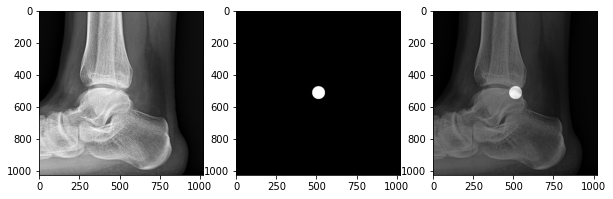

load weight
Use GPU: cuda for training
900/900: [===============================>] - ETA 1.3s    
Epoch: 1. Train Dice:0.89728. Train Loss:0.10272
123/123: [===============================>] - ETA 0.2s   
Epoch: 1. Val Dice:0.92300. Val Loss:0.07700
********************************************************************************
model_save! /workspace/flat_feet/Unet/weight_unet1024_noSCSE//24/weight.pth
********************************************************************************
  4/900: [>...............................] - ETA 0.0s  

RuntimeError: CUDA out of memory. Tried to allocate 160.00 MiB (GPU 0; 47.46 GiB total capacity; 13.81 GiB already allocated; 97.31 MiB free; 14.96 GiB reserved in total by PyTorch)

In [4]:
maximum_loss = [1.0]*25
for LN in range(24,25,1):

#     DIR = '/mnt/nas125/InHwanKim/data/rsm/data(600)/'
# #     DIR = '/workspace/flat_feet/Unet/'

#     x_train = np.load(DIR + "train_images.npy")
#     y_train = np.load(DIR + "train_points.npy")
#     x_val = np.load(DIR + "valid_images.npy")
#     y_val = np.load(DIR + "valid_points.npy")
    
#     x_train = natsorted(glob.glob('/workspace/flat_feet/dataset/flat_feet/image/*.png'))[:900]
#     y_train = natsorted(glob.glob('/workspace/flat_feet/dataset/flat_feet/label/*.npy'))[:900]
#     x_val = natsorted(glob.glob('/workspace/flat_feet/dataset/flat_feet/image/*.png'))[900:1023]
#     y_val = natsorted(glob.glob('/workspace/flat_feet/dataset/flat_feet/label/*.npy'))[900:1023]
    
    #x_test = np.load(DIR + "pjw_x_test.npy")
    #y_test = np.load(DIR + "pjw_y_test.npy")

    transform_train = transforms.Compose([
    Gamma_2D(),
    Shift_2D(),
    RandomBrightness(),
    Rotation_2D(),
    RandomSharp(),
    RandomBlur(),
    RandomNoise(),
    Invert(),
    RandomClahe(),
    ToTensor(),
    ])

    transform_test = transforms.Compose([
        ToTensor(),
    ])


    trainset = Dental_Single_Data_Generator(
        image_size, x_train, y_train, landmark_num = LN, mode = "train", transform=transform_train
    )
    trainloader = DataLoader(trainset, batch_size=train_batch, shuffle=True)

    testset = Dental_Single_Data_Generator(
        image_size, x_val, y_val, landmark_num = LN, mode = "train", transform=transform_test
    )
    testloader = DataLoader(testset, batch_size=1, shuffle=False)
    
    for j in range(0,1,1):
        sample = next(iter(testloader))
        image = sample['image'][0]
        mask = sample['landmarks'][0]
        
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 3, 1)
        image = np.squeeze(image,0)
        plt.imshow(image, 'gray')
        plt.subplot(1, 3, 2)
        mask = np.squeeze(mask,0)
        plt.imshow(mask,'gray')
        plt.subplot(1, 3, 3)
        print(image.shape, mask.shape)
        add = image + mask
        plt.imshow(add,'gray')
        plt.show() 
        
    
#     model = UNet(n_channels = 1, n_classes = 1)
    import segmentation_models_pytorch as smp
    # model = smp.Unet(encoder_name='timm-tf_efficientnet_lite4',decoder_attention_type='scse', in_channels = 1, classes = 1)
    model = smp.Unet(encoder_name='timm-tf_efficientnet_lite4',decoder_attention_type=None, in_channels = 1, classes = 1)
    # model = smp.Unet(encoder_name='vgg16', decoder_attention_type='scse', in_channels = 1, classes = 1)
    try:
        weight_file = natsorted(glob.glob(HISTORY_PATH+str(LN)+'/*'))[-1]
        weight = torch.load(weight_file)
        model.load_state_dict(weight)
        print('load weight')
    except:
        print('no weight')
    
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")      
        model = nn.DataParallel(model)

    device = torch.device('cuda')

    if device is not None:
        print("Use GPU: {} for training".format(device))

    if not torch.cuda.is_available():
        print('using CPU, this will be slow')
    else:
        model.to(device)

    #summary(model, input_size=(1, 512, 512))
    best_acc_wts = copy.deepcopy(model.state_dict())

    #criterion = BinaryDiceLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)    
    
    mean_train_losses = []
    mean_val_losses = []
    
    for epoch in range(10):
        train_losses = []
        train_dice = []
        val_losses = []
        val_dice = []
        
        
        for batch_idx, sample in enumerate(Bar(trainloader)):    

            images,masks = sample['image'].to(device), sample['landmarks'].to(device)

            outputs = model(images)
            outputs= torch.sigmoid(outputs)

            loss = dice_loss(outputs, masks)
            ddice = dice(outputs, masks)

            train_losses.append(loss.data.cpu().numpy())
            train_dice.append(ddice.data.cpu().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print('Epoch: {}. Train Dice:{:.5f}. Train Loss:{:.5f}'.format(epoch+1, np.mean(train_dice), np.mean(train_losses)))

        for batch_idx, sample in enumerate(Bar(testloader)):    
            images,masks = sample['image'].to(device), sample['landmarks'].to(device)

            outputs = model(images)
            outputs= torch.sigmoid(outputs)
            loss = dice_loss(outputs, masks)
            ddice = dice(outputs, masks)
            val_losses.append(loss.data.cpu().numpy())
            val_dice.append(ddice.data.cpu().numpy())
            
        print('Epoch: {}. Val Dice:{:.5f}. Val Loss:{:.5f}'.format(epoch+1, np.mean(val_dice), np.mean(val_losses)))

        mean_train_losses.append(np.mean(train_losses))
        mean_val_losses.append(np.mean(val_losses))
        # Print Loss
        if(np.mean(val_losses) < maximum_loss[LN]):
            maximum_loss[LN] = np.mean(val_losses)
            
            directory = HISTORY_PATH  + "/" +str(LN)
            
            if not os.path.exists(directory):
                os.makedirs(directory)
                
            filename = directory  + "/"  +'weight.pth'                          
            torch.save(model.state_dict(), filename)
            print("*"*80)
            print("model_save!",filename)
            print("*"*80)